In [1]:
from numpy import *
import matplotlib.pyplot as plt

In [2]:
def loadDataSet(fileName):
    """
    对文件进行逐行解析，从而得到第行的类标签和整个特征矩阵
    Args:        fileName 文件名    
    Returns:        
        dataMat  特征矩阵
        labelMat 类标签
    """
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat, labelMat


## 辅助函数

In [3]:
def selectJrand(i, m):
    """随机选择一个整数
    Args:
        i  第一个alpha的下标
        m  所有alpha的数目
    Returns:
        j  返回一个不为i的随机数，在0~m之间的整数值
    """
    j = i
    while(j == i):
        j = int(random.uniform(0, m))
    return j


def clipAlpha(aj, H, L):
    """clipAlpha(调整aj的值，使aj处于 L<=aj<=H)
    Args:
        aj  目标值
        H   最大值
        L   最小值
    Returns:
        aj  目标值
    """
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [4]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    """
    smoSimple
    Args:
        dataMatIn    特征集合
        classLabels  类别标签
        C   松弛变量(常量值)，允许有些数据点可以处于分隔面的错误一侧。
            控制最大化间隔和保证大部分的函数间隔小于1.0这两个目标的权重。
            可以通过调节该参数达到不同的结果。
        toler   容错率（是指在某个体系中能减小一些因素或选择对某个系统产生不稳定的概率。）
        maxIter 退出前最大的循环次数
    Returns:
        b       模型的常量值
        alphas  拉格朗日乘子
    """
    dataMatrix = mat(dataMatIn)
    # 矩阵转置 和 .T 一样的功能
    labelMat = mat(classLabels).transpose()
    m, n = shape(dataMatrix)

    # 初始化 b和alphas(alpha有点类似权重值。)
    b = 0
    alphas = mat(zeros((m, 1)))

    # 没有任何alpha改变的情况下遍历数据的次数
    iter = 0
    while (iter < maxIter):
        # w = calcWs(alphas, dataMatIn, classLabels)
        # print("w:", w)

        # 记录alpha是否已经进行优化，每次循环时设为0，然后再对整个集合顺序遍历
        alphaPairsChanged = 0
        for i in range(m):
            # print 'alphas=', alphas
            # print 'labelMat=', labelMat
            # print 'multiply(alphas, labelMat)=', multiply(alphas, labelMat)
            # 我们预测的类别 y[i] = w^Tx[i]+b; 其中因为 w = Σ(1~n) a[n]*lable[n]*x[n]
            fXi = float(multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[i, :].T)) + b
            # 预测结果与真实结果比对，计算误差Ei
            Ei = fXi - float(labelMat[i])

            # 约束条件 (KKT条件是解决最优化问题的时用到的一种方法。我们这里提到的最优化问题通常是指对于给定的某一函数，求其在指定作用域上的全局最小值)
            # 0<=alphas[i]<=C，但由于0和C是边界值，我们无法进行优化，因为需要增加一个alphas和降低一个alphas。
            # 表示发生错误的概率：labelMat[i]*Ei 如果超出了 toler， 才需要优化。至于正负号，我们考虑绝对值就对了。
            '''
                # 检验训练样本(xi, yi)是否满足KKT条件
                yi*f(i) >= 1 and alpha = 0 (outside the boundary)
                yi*f(i) == 1 and 0<alpha< C (on the boundary)
                yi*f(i) <= 1 and alpha = C (between the boundary)
            '''
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):

                # 如果满足优化的条件，我们就随机选取非i的一个点，进行优化比较
                j = selectJrand(i, m)
                # 预测j的结果
                fXj = float(multiply(alphas, labelMat).T*(dataMatrix*dataMatrix[j, :].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()
                alphaJold = alphas[j].copy()

                # L和H用于将alphas[j]调整到0-C之间。如果L==H，就不做任何改变，直接执行continue语句
                # labelMat[i] != labelMat[j] 表示异侧，就相减，否则是同侧，就相加。
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # 如果相同，就没发优化了
                if L == H:
                    print("L==H")
                    continue

                # eta是alphas[j]的最优修改量，如果eta==0，需要退出for循环的当前迭代过程
                # 参考《统计学习方法》李航-P125~P128<序列最小最优化算法>
                eta = 2.0 * dataMatrix[i, :]*dataMatrix[j, :].T - dataMatrix[i, :]*dataMatrix[i, :].T - dataMatrix[j, :]*dataMatrix[j, :].T
                if eta >= 0:
                    print("eta>=0")
                    continue

                # 计算出一个新的alphas[j]值
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                # 并使用辅助函数，以及L和H对其进行调整
                alphas[j] = clipAlpha(alphas[j], H, L)
                # 检查alpha[j]是否只是轻微的改变，如果是的话，就退出for循环。
                if (abs(alphas[j] - alphaJold) < 0.00001):
                    print("j not moving enough")
                    continue
                # 然后alphas[i]和alphas[j]同样进行改变，虽然改变的大小一样，但是改变的方向正好相反
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                # 在对alpha[i], alpha[j] 进行优化之后，给这两个alpha值设置一个常数b。
                # w= Σ[1~n] ai*yi*xi => b = yj- Σ[1~n] ai*yi(xi*xj)
                # 所以：  b1 - b = (y1-y) - Σ[1~n] yi*(a1-a)*(xi*x1)
                # 为什么减2遍？ 因为是 减去Σ[1~n]，正好2个变量i和j，所以减2遍
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[i, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i, :]*dataMatrix[j, :].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i, :]*dataMatrix[j, :].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j, :]*dataMatrix[j, :].T
                if (0 < alphas[i]) and (C > alphas[i]):
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter, i, alphaPairsChanged))
        # 在for循环外，检查alpha值是否做了更新，如果在更新则将iter设为0后继续运行程序
        # 知道更新完毕后，iter次循环无变化，才推出循环。
        if (alphaPairsChanged == 0):
            iter += 1
        else:
            iter = 0
        print("iteration number: %d" % iter)
    return b, alphas


## 画图

In [5]:
def plotfig_SVM(xMat, yMat, ws, b, alphas):
    """
    参考地址：
       http://blog.csdn.net/maoersong/article/details/24315633
       http://www.cnblogs.com/JustForCS/p/5283489.html
       http://blog.csdn.net/kkxgx/article/details/6951959
    """

    xMat = mat(xMat)
    yMat = mat(yMat)

    # b原来是矩阵，先转为数组类型后其数组大小为（1,1），所以后面加[0]，变为(1,)
    b = array(b)[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 注意flatten的用法
    ax.scatter(xMat[:, 0].flatten().A[0], xMat[:, 1].flatten().A[0])

    # x最大值，最小值根据原数据集dataArr[:, 0]的大小而定
    x = arange(-1.0, 10.0, 0.1)

    # 根据x.w + b = 0 得到，其式子展开为w0.x1 + w1.x2 + b = 0, x2就是y值
    y = (-b-ws[0, 0]*x)/ws[1, 0]
    ax.plot(x, y)

    for i in range(shape(yMat[0, :])[1]):
        if yMat[0, i] > 0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'cx')
        else:
            ax.plot(xMat[i, 0], xMat[i, 1], 'kp')

    # 找到支持向量，并在图中标红
    for i in range(100):
        if alphas[i] > 0.0:
            ax.plot(xMat[i, 0], xMat[i, 1], 'ro')
    plt.show()


## 回归系数

In [6]:
def calcWs(alphas, dataArr, classLabels):
    """
    基于alpha计算w值
    Args:
        alphas        拉格朗日乘子
        dataArr       feature数据集
        classLabels   目标变量数据集

    Returns:
        wc  回归系数
    """
    X = mat(dataArr)
    labelMat = mat(classLabels).transpose()
    m, n = shape(X)
    w = zeros((n, 1))
    for i in range(m):
        w += multiply(alphas[i] * labelMat[i], X[i, :].T)
    return w


In [7]:
dataMat, labelMat = loadDataSet('6.SVM/testSet.txt')

In [8]:
b, alphas = smoSimple(dataMat, labelMat, 0.6, 0.001, 40)

L==H
iter: 0 i:1, pairs changed 1
L==H
j not moving enough
L==H
iter: 0 i:7, pairs changed 2
L==H
L==H
iter: 0 i:11, pairs changed 3
iter: 0 i:17, pairs changed 4
iter: 0 i:22, pairs changed 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
iteration number: 0
iter: 0 i:1, pairs changed 1
iter: 0 i:7, pairs changed 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i:54, pairs changed 3
iter: 0 i:55, pairs changed 4
j not moving enough
iteration number: 0
j not moving enough
L==H
j not moving enough
j not moving enough
iter: 0 i:21, pairs changed 1
L==H
L==H
iter: 0 i:25, pairs changed 2
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0

j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 3 i:55, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration 

j not moving enough
iteration number: 20
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 20 i:55, pairs changed 1
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
j not moving enough
j not mo

In [9]:
shape(alphas[alphas>0])

(1, 4)

In [15]:
res = alphas[alphas>0]

In [19]:
for i in range(100):
    if alphas[i]>0:
        print(dataMat[i], labelMat[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[2.893743, -1.643468] -1.0
[6.080573, 0.418886] 1.0


In [20]:
res

matrix([[1.27463318e-01, 2.41385582e-01, 4.95430795e-05, 3.68898443e-01]])

In [12]:
ws = calcWs(alphas, dataMat, labelMat)

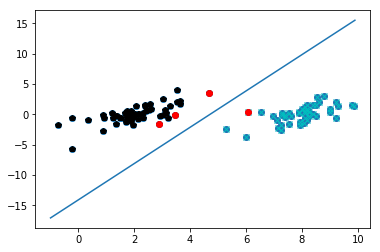

In [13]:
plotfig_SVM(dataMat, labelMat, ws, b, alphas)